<a href="https://colab.research.google.com/github/varJATIN/Ocular-fundus-image-Analysis/blob/main/FastAIDRGrading_IIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install fastai==1.0.42

In [ ]:
import os
 
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt
import cv2
 
from sklearn.model_selection import train_test_split
 
from PIL import Image
 
pd.set_option('display.max_colwidth',1000) # to avoid output truncation

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
print('Make sure cuda is installed:', torch.cuda.is_available())
print('Make sure cudnn is enabled:', torch.backends.cudnn.enabled)

Make sure cuda is installed: True
Make sure cudnn is enabled: True


#Train Data Read

In [ ]:
dataset_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set"
dataset_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv"
 
df = pd.read_csv(dataset_groundtruth_location)
df_ = pd.DataFrame();
df_['path'] = dataset_images_location + '/' + df['Image name'] + ".jpg"
df_['level'] = df['Retinopathy grade']
df = df_
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
#df['level'] = df['level'].astype('int32')
# df.head(10)
print(df)
 
img = cv2.imread(df['path'][1])
print(img.dtype)

                                                                                                  path  level
0    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_109.jpg      2
1    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_104.jpg      4
2    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_076.jpg      2
3    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_268.jpg      0
4    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_099.jpg      3
..                                                                                                 ...    ...
408  /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_335.jpg      0
409  /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_130.jpg      2
410  /cont

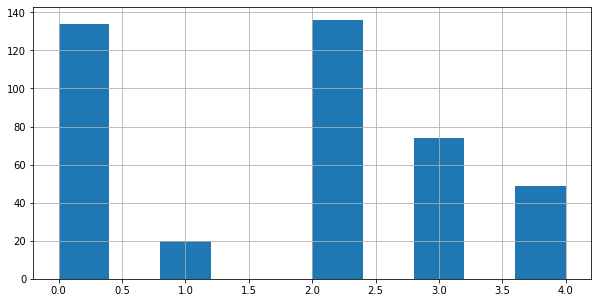

In [ ]:
df['level'].hist(figsize = (10, 5))

In [ ]:
df.pivot_table(index='level', aggfunc=len)

,path
level,
0,134
1,20
2,136
3,74
4,49


In [ ]:
def balance_data(class_size,df):
    train_df = df.groupby(['level']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['level'].hist(figsize = (10, 5))
    return train_df

In [ ]:
train_df, val_df = train_test_split(df,test_size=0.2) # Here we will perform an 80%/20% split of the dataset, with stratification to keep similar distribution in validation set

83

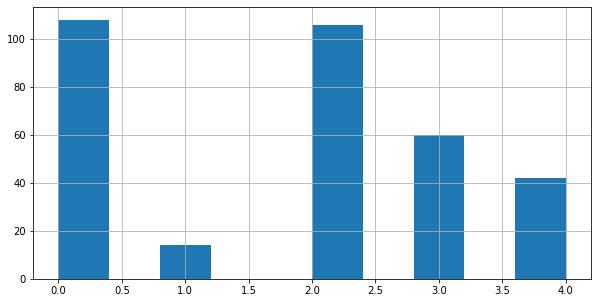

In [ ]:
train_df['level'].hist(figsize = (10, 5))
len(val_df)

In [ ]:
train_df.pivot_table(index='level', aggfunc=len)

,path
level,
0,108
1,14
2,106
3,60
4,42


New Data Size: 540 Old Size: 330


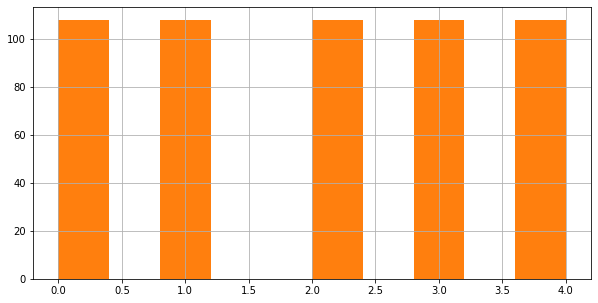

In [ ]:
train_df = balance_data(train_df.pivot_table(index='level', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
train_df['level'].hist(figsize = (10, 5))

In [ ]:
df = pd.concat([train_df,val_df]) #beginning of this dataframe is the oversampled training set, end is the validation set
len(df)
print(df)

                                                                                                  path  level
0    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_398.jpg      2
1    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_075.jpg      3
2    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_403.jpg      1
3    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_339.jpg      3
4    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_253.jpg      3
..                                                                                                 ...    ...
118  /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_151.jpg      0
27   /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_004.jpg      3
240  /cont

In [ ]:
im = Image.open(train_df['path'][1])
width, height = im.size
# im.show
# print(width,height)

In [ ]:
bs = 16 #smaller batch size is better for training, but may take longer
sz=224
print(len(train_df))
print(len(val_df))
print(len(df))

540
83
623


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [ ]:
tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=360,max_warp=0,max_zoom=1.1,max_lighting=0.1,p_lighting=0.5)
 
data = ImageDataBunch.from_df(path = '/', df = df, ds_tfms = tfms, size = sz, valid_pct = (len(val_df) / len(df)), bs = bs)
data = data.normalize(imagenet_stats)
print(data)

ImageDataBunch;

Train: LabelList (540 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
2,3,1,3,3
Path: /;

Valid: LabelList (83 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,3,3,4,2
Path: /;

Test: None


[0, 1, 2, 3, 4]


(5, 5)

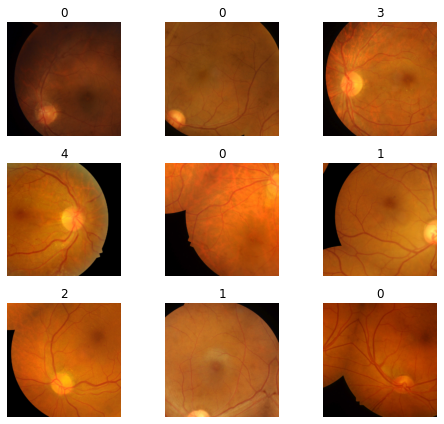

In [ ]:
data.show_batch(rows=3, figsize=(7,6))

print(data.classes)
len(data.classes),data.c

#Transfer Learning

In [ ]:
from sklearn.metrics import cohen_kappa_score
def quadratic_kappa(y_hat, y):
    return torch.tensor(cohen_kappa_score(torch.argmax(y_hat.cpu(),1), y.cpu(), weights='quadratic'),device='cuda:0')

In [ ]:
import torchvision
learn = create_cnn(data, models.resnet50, metrics = [accuracy,quadratic_kappa])

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [ ]:
# learn.lr_find()

In [ ]:
# learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(4,max_lr = 0.0016)


epoch,train_loss,valid_loss,accuracy,quadratic_kappa,time
0,2.118437,1.652144,0.530120,0.711229,02:35
1,1.831250,1.660015,0.590361,0.725915,02:32
2,1.595016,1.117145,0.674699,0.841130,02:35
3,1.341041,1.073865,0.662651,0.793183,02:31


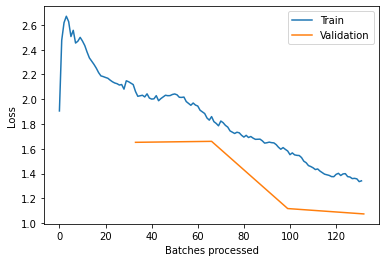

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-1-224')
# see how to load the model

In [ ]:
learn.unfreeze()

In [ ]:
# learn.lr_find()

In [ ]:
# learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, max_lr=slice(0.0000016,0.00016))

epoch,train_loss,valid_loss,accuracy,quadratic_kappa,time
0,1.041472,1.164465,0.686747,0.816088,02:33
1,1.006003,1.175342,0.674699,0.766888,02:32
2,0.903312,1.153966,0.710843,0.811118,02:32
3,0.921659,1.174461,0.686747,0.796472,02:30


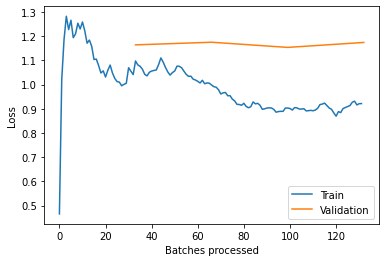

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2-224')

#Progressive Resizing

In [ ]:
dataNew = ImageDataBunch.from_df(path = '/', df = df, ds_tfms = tfms, size = sz * 2, valid_pct = (len(val_df) / len(df)), bs = 4)
dataNew = dataNew.normalize(imagenet_stats)

In [ ]:
learn.data = dataNew
dataNew.train_ds[0][0].shape

torch.Size([3, 448, 448])

In [ ]:
learn.freeze()

In [ ]:
# learn.lr_find()
# learn.recorder.plot()

Min numerical gradient: 3.46E-05
Min loss divided by 10: 6.48E-07


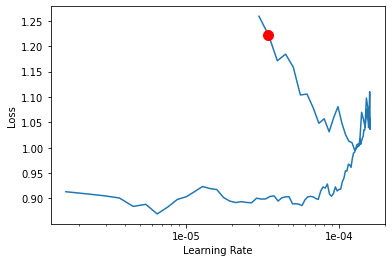

In [ ]:
learn.recorder.plot(suggestion = True)

In [ ]:
learn.fit_one_cycle(4,max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,quadratic_kappa,time
0,1.820246,1.306646,0.602410,0.740525,03:04
1,1.919639,0.882678,0.650602,0.688009,03:02
2,1.446444,0.730928,0.722892,0.793480,03:05
3,1.198612,0.596134,0.807229,0.835169,03:04


In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-1-448')

In [ ]:
learn.unfreeze()

In [ ]:
# learn.lr_find()
# learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4,max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,quadratic_kappa,time
0,1.390206,0.630330,0.783133,0.864748,03:07
1,1.388831,0.528127,0.855422,0.878390,03:08
2,1.275245,0.652531,0.734940,0.828973,03:04
3,1.232278,0.586474,0.783133,0.843660,03:06


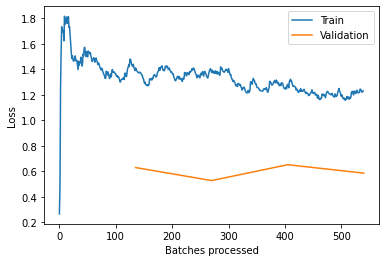

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2-448')

#Checking Results

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

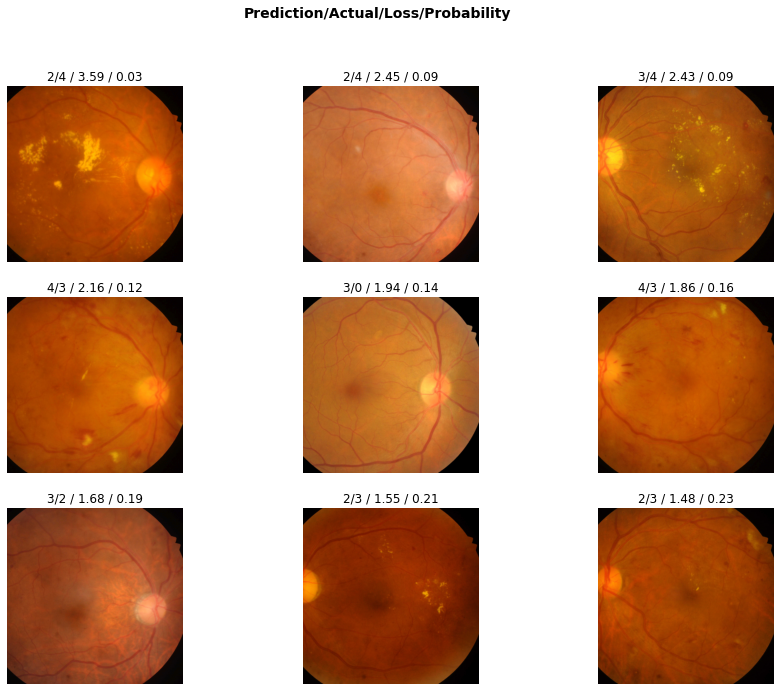

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

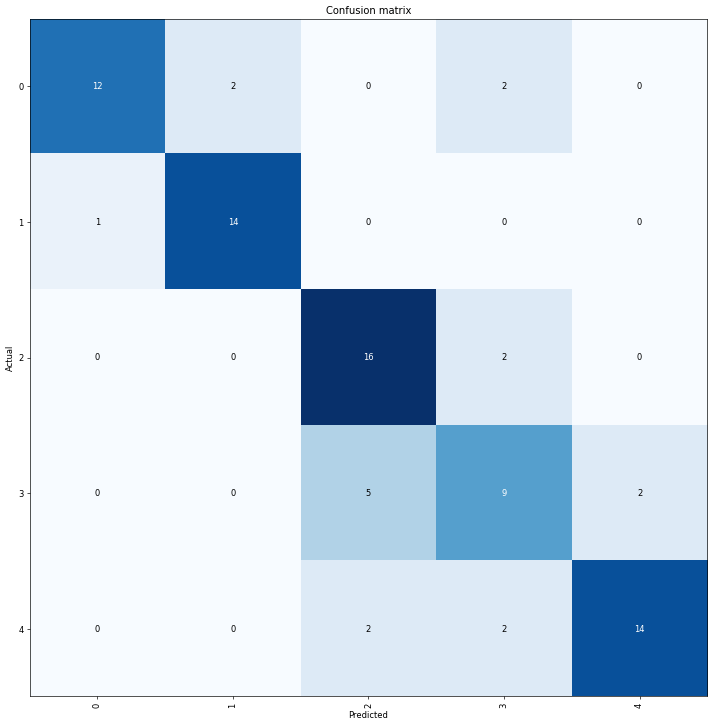

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Testing Data

In [ ]:
test_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set"
test_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv"

test_df = pd.read_csv(test_groundtruth_location)
test_df_ = pd.DataFrame();
test_df_['path'] = test_images_location + '/' + test_df['Image name'] + ".jpg"
test_df_['level'] = test_df['Retinopathy grade']
test_df = test_df_

print(test_df)

                                                                                                 path  level
0    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_001.jpg      4
1    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_002.jpg      4
2    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_003.jpg      4
3    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_004.jpg      4
4    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_005.jpg      4
..                                                                                                ...    ...
98   /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_099.jpg      0
99   /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_100.jpg      2
100  /content/drive

In [ ]:
# Create a test set to pass to our learner
test = (ImageList.from_df(path='/', df=test_df))
learn.data.add_test(test)

In [ ]:
# Get predictions
preds1, l1 = learn.get_preds(DatasetType.Test)
preds2, l2 = learn.TTA(ds_type=DatasetType.Test)

In [ ]:
preds1

tensor([[2.5068e-02, 1.4526e-03, 6.1641e-02, 1.1997e-01, 7.9186e-01],
        [3.5242e-01, 3.6756e-02, 3.3086e-01, 8.6603e-02, 1.9336e-01],
        [2.3929e-01, 3.6398e-02, 2.5065e-01, 2.8969e-01, 1.8397e-01],
        [4.3393e-01, 1.5940e-02, 6.5355e-02, 2.7655e-01, 2.0823e-01],
        [2.4306e-01, 1.0281e-02, 3.4476e-01, 1.7760e-01, 2.2429e-01],
        [1.3752e-01, 8.7493e-02, 4.2328e-01, 3.0938e-01, 4.2323e-02],
        [5.1811e-03, 4.8463e-03, 2.4147e-01, 3.5390e-01, 3.9461e-01],
        [2.7788e-01, 4.5895e-02, 5.1355e-01, 6.1062e-02, 1.0162e-01],
        [4.6478e-03, 2.6676e-03, 9.2538e-01, 5.0987e-02, 1.6313e-02],
        [4.7522e-02, 5.3044e-02, 2.6964e-01, 6.2226e-01, 7.5330e-03],
        [6.0753e-02, 5.2953e-03, 6.7777e-01, 2.5262e-01, 3.5546e-03],
        [3.6183e-01, 5.9365e-01, 3.7282e-02, 6.3225e-03, 9.1152e-04],
        [7.1263e-03, 1.1068e-02, 1.2242e-01, 8.0567e-01, 5.3715e-02],
        [1.0082e-02, 3.7543e-02, 3.0155e-01, 7.6869e-02, 5.7396e-01],
        [3.9782e-03,

In [ ]:
preds2

tensor([[5.2337e-02, 6.1748e-03, 9.0209e-02, 7.5898e-02, 7.7538e-01],
        [2.7056e-01, 8.7450e-02, 3.7632e-01, 7.7615e-02, 1.8806e-01],
        [1.6952e-01, 1.7556e-01, 3.3719e-01, 1.5318e-01, 1.6455e-01],
        [5.3745e-01, 4.4890e-02, 4.9137e-02, 1.4096e-01, 2.2756e-01],
        [3.4414e-01, 7.2499e-03, 2.2040e-01, 8.5126e-02, 3.4308e-01],
        [1.2623e-01, 1.0065e-01, 2.5961e-01, 2.2960e-01, 2.8392e-01],
        [1.6648e-02, 3.0984e-02, 2.0015e-01, 1.9263e-01, 5.5959e-01],
        [1.3115e-01, 5.9937e-02, 4.3122e-01, 1.0406e-01, 2.7364e-01],
        [5.7286e-03, 9.5319e-03, 8.5307e-01, 5.0581e-02, 8.1087e-02],
        [6.1792e-02, 1.2337e-01, 3.7744e-01, 3.3144e-01, 1.0597e-01],
        [9.5007e-02, 4.1815e-03, 5.9433e-01, 2.7215e-01, 3.4337e-02],
        [2.1515e-01, 6.2934e-01, 1.3440e-01, 1.3873e-02, 7.2299e-03],
        [8.9854e-03, 3.4370e-02, 1.5304e-01, 6.5030e-01, 1.5330e-01],
        [1.2728e-02, 6.6253e-02, 4.4114e-01, 6.1104e-02, 4.1878e-01],
        [6.6459e-03,

In [ ]:
preds1 = np.array(preds1)
preds2 = np.array(preds2)
print("preds1", preds1.shape)
print("preds2", preds2.shape)

preds1 (103, 5)
preds2 (103, 5)


In [ ]:
preds1 = np.argmax(preds1, axis = 1)
preds2 = np.argmax(preds2, axis = 1)
print("preds1", preds1.shape)
print("preds2", preds2.shape)

preds1 (103,)
preds2 (103,)


In [ ]:
labels = test_df['level']
labels.shape

(103,)

In [ ]:
preds1

array([4, 0, 3, 0, ..., 2, 2, 2, 1])

In [ ]:
preds2

array([4, 2, 2, 0, ..., 2, 2, 2, 1])

In [ ]:
from sklearn.metrics import accuracy_score
print("preds1", accuracy_score(labels, preds1))
print("preds2", accuracy_score(labels, preds2))

preds1 0.5242718446601942
preds2 0.4368932038834951


[[20  8  5  1  0]
 [ 1  1  3  0  0]
 [ 2  4 21  5  0]
 [ 1  0  5  9  4]
 [ 2  0  5  3  3]]


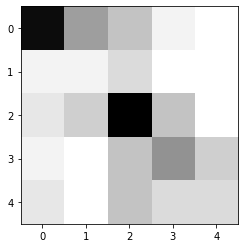

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels, preds1) 
print(cm)
plt.imshow(cm, cmap = 'binary')

[[14 15  4  1  0]
 [ 1  1  3  0  0]
 [ 2  4 19  5  2]
 [ 1  1  5  6  6]
 [ 2  0  6  0  5]]


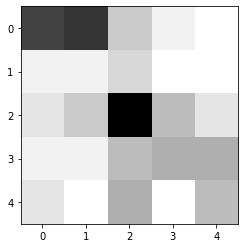

In [ ]:
cm = confusion_matrix(labels, preds2) 
print(cm)
plt.imshow(cm, cmap = 'binary')

In [ ]:
# TTA is easy - use .TTA() in place of .get_preds()
# preds_tta, labels_tta = learn.TTA(ds_type=DatasetType.Test)

In [ ]:
# acc_tta = accuracy(preds_tta, labels_tta)
# print(acc_tta)

In [ ]:
# test_images = []
# im_size = 224
# for image_path in df['path']:
#     img = cv2.imread(image_path)
#     img = cv2.resize(img, (im_size, im_size));
#     test_images.append(img);

In [ ]:
# test_pred = learn.predict_array(test_imgs)
# test_pred = np.argmax(test_pred, axis=1)
# test_pred